<a href="https://colab.research.google.com/github/a-panagiotic/NeuralNetworks-Unofficial/blob/main/%CE%86%CF%83%CE%BA%CE%B7%CF%83%CE%B7_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Εργαστηριακή Άσκηση 2. Μη επιβλεπόμενη μάθηση. 
## Σύστημα συστάσεων βασισμένο στο περιεχόμενο
## Σημασιολογική απεικόνιση δεδομένων με χρήση SOM 
Ημερομηνία εκφώνησης της άσκησης: 23 Νοεμβρίου 2020



### **Στοιχεία ομάδας**
#### Ομάδα 15
#### Μαρίνος Τζανίκος 03113147, el13147@mail.ntua.gr
#### Γιώργος Γκανάς 03116095, el16095@mail.ntua.gr
#### Παναγιώτης Αϊβασιλιώτης 03116176, el16176@mail.ntua.gr

In [1]:
!pip install --upgrade pip
!pip install --upgrade numpy
!pip install --upgrade pandas
!pip install --upgrade nltk
!pip install --upgrade scikit-learn
!pip install --upgrade joblib

## Εισαγωγή του Dataset

Το σύνολο δεδομένων με το οποίο θα δουλέψουμε είναι βασισμένο στο [Carnegie Mellon Movie Summary Corpus](http://www.cs.cmu.edu/~ark/personas/). Πρόκειται για ένα dataset με περίπου 40.000 περιγραφές ταινιών. Η περιγραφή κάθε ταινίας αποτελείται από τον τίτλο της, μια ή περισσότερες ετικέτες που χαρακτηρίζουν το είδος της ταινίας και τέλος τη σύνοψη της υπόθεσής της. Αρχικά εισάγουμε το dataset (χρησιμοποιήστε αυτούσιο τον κώδικα, δεν χρειάζεστε το αρχείο csv) στο dataframe `df_data_1`: 

In [2]:
import pandas as pd

dataset_url = "https://drive.google.com/uc?export=download&id=1PdkVDENX12tQliCk_HtUnAUbfxXvnWuG"
df_data_1 = pd.read_csv(dataset_url, sep='\t',  header=None, quoting=3, error_bad_lines=False)

Κάθε ομάδα θα δουλέψει σε ένα μοναδικό υποσύνολο 5.000 ταινιών (διαφορετικό dataset για κάθε ομάδα) ως εξής

1. Κάθε ομάδα έχει έναν αριθμό "seed" (φύτρο) που είναι ο ίδιος με τον αριθμό της ομάδας σας: θα τον βρείτε στην κολόνα Α/Α [εδώ](https://docs.google.com/spreadsheets/d/1CD6AtX7YnocXceCELl_XJ06kyRr0YQPhor8dpw012t0/edit?usp=sharing).

2. Το data frame `df_data_2` έχει γραμμές όσες και οι ομάδες και 5.000 στήλες. Σε κάθε ομάδα αντιστοιχεί η γραμμή του πίνακα με το `team_seed_number` της. Η γραμμή αυτή θα περιλαμβάνει 5.000 διαφορετικούς αριθμούς που αντιστοιχούν σε ταινίες του αρχικού dataset. 

3. Στο επόμενο κελί αλλάξτε τη μεταβλητή `team_seed_number` με το Seed της ομάδας σας.

4. Τρέξτε τον κώδικα. Θα προκύψουν τα μοναδικά για κάθε ομάδα  titles, categories, catbins, summaries και corpus με τα οποία θα δουλέψετε.

In [3]:
import numpy as np

# βάλτε το seed που αντιστοιχεί στην ομάδα σας
team_seed_number = 15

movie_seeds_url = "https://drive.google.com/uc?export=download&id=1EA_pUIgK5Ub3kEzFbFl8wSRqAV6feHqD"
df_data_2 = pd.read_csv(movie_seeds_url, header=None, error_bad_lines=False)

# επιλέγεται 
my_index = df_data_2.iloc[team_seed_number,:].values

titles = df_data_1.iloc[:, [2]].values[my_index] # movie titles (string)
categories = df_data_1.iloc[:, [3]].values[my_index] # movie categories (string)
bins = df_data_1.iloc[:, [4]]
catbins = bins[4].str.split(',', expand=True).values.astype(np.float)[my_index] # movie categories in binary form (1 feature per category)
summaries =  df_data_1.iloc[:, [5]].values[my_index] # movie summaries (string)
corpus = summaries[:,0].tolist() # list form of summaries

- Ο πίνακας **titles** περιέχει τους τίτλους των ταινιών. Παράδειγμα: 'Sid and Nancy'.
- O πίνακας **categories** περιέχει τις κατηγορίες (είδη) της ταινίας υπό τη μορφή string. Παράδειγμα: '"Tragedy",  "Indie",  "Punk rock",  "Addiction Drama",  "Cult",  "Musical",  "Drama",  "Biopic \[feature\]",  "Romantic drama",  "Romance Film",  "Biographical film"'. Παρατηρούμε ότι είναι μια comma separated λίστα strings, με κάθε string να είναι μια κατηγορία.
- Ο πίνακας **catbins** περιλαμβάνει πάλι τις κατηγορίες των ταινιών αλλά σε δυαδική μορφή ([one hot encoding](https://hackernoon.com/what-is-one-hot-encoding-why-and-when-do-you-have-to-use-it-e3c6186d008f)). Έχει διαστάσεις 5.000 x 322 (όσες οι διαφορετικές κατηγορίες). Αν η ταινία ανήκει στο συγκεκριμένο είδος η αντίστοιχη στήλη παίρνει την τιμή 1, αλλιώς παίρνει την τιμή 0.
- Ο πίνακας **summaries** και η λίστα **corpus** περιλαμβάνουν τις συνόψεις των ταινιών (η corpus είναι απλά ο summaries σε μορφή λίστας). Κάθε σύνοψη είναι ένα (συνήθως μεγάλο) string. Παράδειγμα: *'The film is based on the real story of a Soviet Internal Troops soldier who killed his entire unit  as a result of Dedovschina. The plot unfolds mostly on board of the prisoner transport rail car guarded by a unit of paramilitary conscripts.'*
- Θεωρούμε ως **ID** της κάθε ταινίας τον αριθμό γραμμής της ή το αντίστοιχο στοιχείο της λίστας. Παράδειγμα: για να τυπώσουμε τη σύνοψη της ταινίας με `ID=99` (την εκατοστή) θα γράψουμε `print(corpus[99])`.

In [4]:
ID = 99
print(titles[ID])
print(categories[ID])
print(catbins[ID])
print(corpus[ID])

['Congkak']
['"Horror"']
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0

# Εφαρμογή 1. Υλοποίηση συστήματος συστάσεων ταινιών βασισμένο στο περιεχόμενο
<img src="http://clture.org/wp-content/uploads/2015/12/Netflix-Streaming-End-of-Year-Posts.jpg" width="70%">

Η πρώτη εφαρμογή που θα αναπτύξετε θα είναι ένα [σύστημα συστάσεων](https://en.wikipedia.org/wiki/Recommender_system) ταινιών βασισμένο στο περιεχόμενο (content based recommender system). Τα συστήματα συστάσεων στοχεύουν στο να προτείνουν αυτόματα στο χρήστη αντικείμενα από μια συλλογή τα οποία ιδανικά θέλουμε να βρει ενδιαφέροντα ο χρήστης. Η κατηγοριοποίηση των συστημάτων συστάσεων βασίζεται στο πώς γίνεται η επιλογή (filtering) των συστηνόμενων αντικειμένων. Οι δύο κύριες κατηγορίες είναι η συνεργατική διήθηση (collaborative filtering) όπου το σύστημα προτείνει στο χρήστη αντικείμενα που έχουν αξιολογηθεί θετικά από χρήστες που έχουν παρόμοιο με αυτόν ιστορικό αξιολογήσεων και η διήθηση με βάση το περιεχόμενο (content based filtering), όπου προτείνονται στο χρήστη αντικείμενα με παρόμοιο περιεχόμενο (με βάση κάποια χαρακτηριστικά) με αυτά που έχει προηγουμένως αξιολογήσει θετικά.

Το σύστημα συστάσεων που θα αναπτύξετε θα βασίζεται στο **περιεχόμενο** και συγκεκριμένα στις συνόψεις των ταινιών (corpus). 


## Μετατροπή σε TFIDF

Το πρώτο βήμα θα είναι λοιπόν να μετατρέψετε το corpus σε αναπαράσταση tf-idf:

In [5]:
import re
import nltk
import string
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('names')
from nltk.corpus import stopwords, names


def preprocess(s) : 
  stemmer = nltk.stem.PorterStemmer()
  #lemmatizer = nltk.stem.WordNetLemmatizer()
  table = str.maketrans('', '', string.punctuation)
  s = (s.lower()).translate(table)
  s = re.sub(r'\d+', 'num', s)
  words = s.split()
  return " ".join([stemmer.stem(word) for word in words])
  #return " ".join([lemmatizer.lemmatize(word) for word in words])

stopwords = stopwords.words('english') + list(string.punctuation) + names.words()

preprocessed_stopwords = preprocess(" ".join(stopwords)).split() + ['becau']




[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package names to /root/nltk_data...
[nltk_data]   Package names is already up-to-date!


Στο βήμα αυτό ορίζουμε τη συνάρτηση `preprocess` που θα χρησιμοποιήσουμε στα δεδομένα για τη μετατροπή TFIDF καθώς και τις stopwords.<br/>
Η προεπεξεργασία εμπεριέχει την εφαρμογή Stemmer ώστε να μη θεωρούνται ξεχωριστές στο χώρο TFIDF διαφορετικές μορφές της ίδιας λέξης, καθώς και μετατροπή σε πεζά γράμματα για τη σωστή λειτουργία του vectorizer. Δοκιμάστηκε και lemmatizer αντί του stemmer, αλλά τα καλύτερα αποτελέσματα παρατηρήθηκαν με τη χρήση stemmer.<br/>

Για τις stopwords χρησιμοποιούμε την αντίστοιχη λίστα που περιέχει για την αγγλική γλώσσα το nltk, σημεία στίξης, καθώς και λίστα ονομάτων που παρέχει το nltk. Το τελευταίο γίνεται ώστε να αποφευχθούν περιπτώσεις όπου ταινίες θεωρούνται όμοιες λόγω της ύπαρξης κοινών (αγγλικών) ονομάτων.

In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(min_df=0.003, max_df=0.025, max_features=2000,
                             stop_words=preprocessed_stopwords, preprocessor=preprocess)
vectorizer.fit(corpus)
corpus_tf_idf = vectorizer.transform(corpus)

/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:391: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abig', 'ainsl', 'alfon', 'aloi', 'alphon', 'anal', 'anali', 'annal', 'annali', 'arl', 'ashl', 'aubr', 'aur', 'beren', 'beverl', 'blakel', 'bonn', 'carr', 'catl', 'cind', 'cord', 'cort', 'darc', 'deed', 'desar', 'desir', 'dorol', 'doroth', 'dorr', 'ebon', 'el', 'eloi', 'emal', 'emmal', 'gerril', 'godfr', 'goo', 'guenev', 'guinev', 'hail', 'heli', 'heloi', 'horten', 'huntl', 'il', 'ili', 'jenil', 'jennil', 'jeral', 'jerril', 'jerryl', 'karal', 'kayc', 'kimberl', 'kirb', 'kiss', 'kizz', 'loral', 'loril', 'magg', 'maril', 'marl', 'marril', 'maryro', 'meli', 'melod', 'merc', 'merral', 'moi', 'mor', 'morl', 'oph', 'ore', 'rival', 'sall', 'salvat', 'shand', 'sheer', 'sidn', 'sind', 'spen', 'tere', 'timoth', 'valar', 'zebed'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


In [7]:
print(corpus_tf_idf.shape)

(5000, 2000)


Οι παραπάνω τιμές των παραμέτρων του `TfidVectorizer` προέκυψαν κατά τη βελτιστοποίηση του συστήματος προτάσεων και θα σχολιαστούν παρακάτω στην αντίστοιχη ενότητα.

In [8]:
from sklearn.feature_extraction.text import CountVectorizer

vec = CountVectorizer().fit(corpus)
bag_of_words = vec.transform(corpus)
sum_words = bag_of_words.sum(axis=0) 
words_freq = [(word, sum_words[0, idx]) for word, idx in     vec.vocabulary_.items()]
words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)

In [9]:
words_freq[120:150]

[('again', 1154),
 ('if', 1149),
 ('becomes', 1134),
 ('leaves', 1130),
 ('soon', 1116),
 ('friends', 1108),
 ('comes', 1100),
 ('years', 1099),
 ('men', 1086),
 ('does', 1080),
 ('leave', 1056),
 ('girl', 1046),
 ('school', 1032),
 ('see', 1023),
 ('named', 1014),
 ('finally', 1013),
 ('asks', 1000),
 ('three', 998),
 ('meanwhile', 995),
 ('kill', 987),
 ('end', 984),
 ('brother', 982),
 ('eventually', 966),
 ('room', 961),
 ('people', 961),
 ('having', 952),
 ('each', 952),
 ('group', 952),
 ('returns', 949),
 ('town', 946)]

In [10]:
vectorizer.get_feature_names()

['abduct',
 'abil',
 'aboard',
 'abort',
 'abroad',
 'abruptli',
 'absenc',
 'academi',
 'access',
 'accomplic',
 'accomplish',
 'accord',
 'account',
 'achiev',
 'acquaint',
 'acquir',
 'actor',
 'actress',
 'ad',
 'adapt',
 'add',
 'addict',
 'addit',
 'address',
 'adjust',
 'admir',
 'adult',
 'advantag',
 'adventur',
 'advertis',
 'advic',
 'advis',
 'afford',
 'afraid',
 'africa',
 'african',
 'afternoon',
 'agenc',
 'aggress',
 'ahead',
 'aircraft',
 'airplan',
 'airport',
 'alarm',
 'alcohol',
 'alert',
 'alien',
 'alleg',
 'alter',
 'altern',
 'amaz',
 'ambit',
 'ambiti',
 'ambush',
 'amongst',
 'amount',
 'amus',
 'ancient',
 'anderson',
 'angrili',
 'anniversari',
 'annoy',
 'anonym',
 'anxiou',
 'anymor',
 'anyway',
 'appeal',
 'appli',
 'appoint',
 'appreci',
 'apprehend',
 'approv',
 'architect',
 'argu',
 'argument',
 'aris',
 'armor',
 'arrog',
 'arrow',
 'articl',
 'artifact',
 'asid',
 'asleep',
 'aspir',
 'assail',
 'assassin',
 'assault',
 'assembl',
 'associ',
 'ass

Η συνάρτηση [TfidfVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) όπως καλείται εδώ **δεν είναι βελτιστοποιημένη**. Οι επιλογές των μεθόδων και παραμέτρων της μπορεί να έχουν **δραματική επίδραση στην ποιότητα των συστάσεων** και είναι διαφορετικές για κάθε dataset. Επίσης, οι επιλογές αυτές έχουν πολύ μεγάλη επίδραση και στη **διαστατικότητα και όγκο των δεδομένων**. Η διαστατικότητα των δεδομένων με τη σειρά της θα έχει πολύ μεγάλη επίδραση στους **χρόνους εκπαίδευσης**, ιδιαίτερα στη δεύτερη εφαρμογή της άσκησης. Ανατρέξτε στα notebooks του εργαστηρίου και στο [FAQ](https://docs.google.com/document/d/1hou1gWXQuHAB7J2aV44xm_CtAWJ63q6Cu1V6OwyL_n0/edit?usp=sharing) των ασκήσεων.


## Υλοποίηση του συστήματος συστάσεων

Το σύστημα συστάσεων που θα παραδώσετε θα είναι μια συνάρτηση `content_recommender` με δύο ορίσματα `target_movie` και `max_recommendations`. Στην `target_movie` περνάμε το ID μιας ταινίας-στόχου για την οποία μας ενδιαφέρει να βρούμε παρόμοιες ως προς το περιεχόμενο (τη σύνοψη) ταινίες, `max_recommendations` στο πλήθος.
Υλοποιήστε τη συνάρτηση ως εξής: 
- για την ταινία-στόχο, από το `corpus_tf_idf` υπολογίστε την [ομοιότητα συνημιτόνου](https://en.wikipedia.org/wiki/Cosine_similarity) της με όλες τις ταινίες της συλλογής σας
- με βάση την ομοιότητα συνημιτόνου που υπολογίσατε, δημιουργήστε ταξινομημένο πίνακα από το μεγαλύτερο στο μικρότερο, με τα indices (`ID`) των ταινιών. Παράδειγμα: αν η ταινία με index 1 έχει ομοιότητα συνημιτόνου με 3 ταινίες \[0.2 1 0.6\] (έχει ομοιότητα 1 με τον εαύτό της) ο ταξινομημένος αυτός πίνακας indices θα είναι \[1 2 0\].
- Για την ταινία-στόχο εκτυπώστε: id, τίτλο, σύνοψη, κατηγορίες (categories)
- Για τις `max_recommendations` ταινίες (πλην της ίδιας της ταινίας-στόχου που έχει cosine similarity 1 με τον εαυτό της) με τη μεγαλύτερη ομοιότητα συνημιτόνου (σε φθίνουσα σειρά), τυπώστε σειρά σύστασης (1 πιο κοντινή, 2 η δεύτερη πιο κοντινή κλπ), id, τίτλο, σύνοψη, κατηγορίες (categories)


In [11]:
from sklearn.metrics.pairwise import cosine_similarity

def content_recommender(target_movie, max_recommendations):
  target_corpus = corpus_tf_idf[target_movie]
  N = corpus_tf_idf.shape[0]
  cos_sims = np.zeros(N)
  for i in range(N):
    cos_sims[i] = cosine_similarity(target_corpus, corpus_tf_idf[i])
  cos_sims_ind = np.argsort(cos_sims)[::-1]
  print("Target movie:\nId: {0}, Title: {1}, Summary: {2}, Categories: {3}".format(
        target_movie, titles[target_movie][0], summaries[target_movie][0], categories[target_movie][0]))
  print("Recommendations:")
  i = 1
  for x in cos_sims_ind[1:max_recommendations+1]:
    print("{0}, Id: {1}, Title: {2}, Summary: {3}, Categories: {4}".format(
          i, x, titles[x][0], summaries[x][0], categories[x][0]))
    i += 1


In [12]:
content_recommender(120, 10)

Target movie:
Id: 120, Title: Babylon 5: The Gathering, Summary:  In the earth year 2257, a multitude of humans and non-humans gather deep in neutral space at a new station, Babylon 5, which has recently become operational. Babylon 5 was built as a neutral venue for discussing and resolving issues between the five major spacefaring races of the galaxy, the humans, Narn, Centauri, Minbari and Vorlons. Commander Jeffrey Sinclair is in overall charge of the station. As the crew awaits the arrival of the fourth and final alien ambassador, Ambassador Kosh Naranek from the Vorlon Empire, a transport ship arrives from Earth, bearing Lyta Alexander, a human telepath who joins the station crew, and Del Varner, a civilian. Ambassador Kosh arrives two days ahead of schedule, and is on board the station less than a minute when he suddenly falls ill, apparently from poisoning. Babylon 5's chief medical officer, Dr. Kyle, conducts a medical investigation and seeks to prevent Kosh's death, while Secu

## Βελτιστοποίηση

Αφού υλοποιήσετε τη συνάρτηση `content_recommender` χρησιμοποιήστε τη για να βελτιστοποιήσετε την `TfidfVectorizer`. Συγκεκριμένα, αρχικά μπορείτε να δείτε τι επιστρέφει το σύστημα για τυχαίες ταινίες-στόχους και για ένα μικρό `max_recommendations` (2 ή 3). Αν σε κάποιες ταινίες το σύστημα μοιάζει να επιστρέφει σημασιολογικά κοντινές ταινίες σημειώστε το `ID` τους. Δοκιμάστε στη συνέχεια να βελτιστοποιήσετε την `TfidfVectorizer` για τα συγκεκριμένα `ID` ώστε να επιστρέφονται σημασιολογικά κοντινές ταινίες για μεγαλύτερο αριθμό `max_recommendations`. Παράλληλα, όσο βελτιστοποιείτε την `TfidfVectorizer`, θα πρέπει να λαμβάνετε καλές συστάσεις για μεγαλύτερο αριθμό τυχαίων ταινιών. Μπορείτε επίσης να βελτιστοποιήσετε τη συνάρτηση παρατηρώντας πολλά φαινόμενα που το σύστημα εκλαμβάνει ως ομοιότητα περιεχομένου ενώ επί της ουσίας δεν είναι επιθυμητό να συνυπολογίζονται (δείτε σχετικά το [FAQ](https://docs.google.com/document/d/1hou1gWXQuHAB7J2aV44xm_CtAWJ63q6Cu1V6OwyL_n0/edit?usp=sharing)). Ταυτόχρονα, μια άλλη κατεύθυνση της βελτιστοποίησης είναι να χρησιμοποιείτε τις παραμέτρους του `TfidfVectorizer` έτσι ώστε να μειώνονται οι διαστάσεις του Vector Space Model μέχρι το σημείο που θα αρχίσει να εμφανίζονται επιπτώσεις στην ποιότητα των συστάσεων. 




## Επεξήγηση επιλογών και ποιοτική ερμηνεία

Σε markdown περιγράψτε πώς προχωρήσατε στις επιλογές σας για τη βελτιστοποίηση της `TfidfVectorizer`. Επίσης σε markdown δώστε 10 παραδείγματα (IDs) από τη συλλογή σας που επιστρέφουν καλά αποτελέσματα μέχρι `max_recommendations` (5 και παραπάνω) και σημειώστε συνοπτικά ποια είναι η θεματική που ενώνει τις ταινίες.

Δείτε [εδώ](https://pastebin.com/raw/ZEvg5t3z) ένα παράδειγμα εξόδου του βελτιστοποιημένου συστήματος συστάσεων για την ταίνία ["Q Planes"](https://en.wikipedia.org/wiki/Q_Planes) με την κλήση της συνάρτησης για κάποιο seed `content_recommender(529,3)`. Είναι φανερό ότι η κοινή θεματική των ταινιών είναι τα αεροπλάνα, οι πτήσεις, οι πιλότοι, ο πόλεμος.

Για τη βελτιστοποίηση του συστήματος συστάσεων, απαιτείται ουσιαστικά η βελτιστοποίηση του συνόλου `corpus_tf_idf` που παράγεται από τον `TfidfVectorizer`. Ταυτοχρόνως, θέλουμε να μειώσουμε τον αριθμό χαρακτηριστικών που περιγράφουν τα δεδομένα μας για πιο γρήγορη εκπαίδευση πάνω σε αυτά. Για αυτό το σκοπό δοκιμάστηκαν διάφοροι συνδυασμοί παραμέτρων και μελετήθηκαν τα αποτελέσματα των ταινιών με id 42 και 120, τα οποία παρατηρήθηκαν από την αρχή να έχουν σχετικά καλές συστάσεις.<br/>
Αρχικά, θέσαμε το `min_df` στο 2 και το `max_df` στο 0.5. Σκοπός είναι με το πρώτο να εξαλείψουμε λέξεις που εμφανίζονται ελάχιστες φορές και άρα δεν προσθέτουν ιδιαίτερα στη διακριτική μας ικανότητα, ενώ με το δεύτερο να εξαλείψουμε λέξεις που εμφανίζονται στα περισσότερα κείμενα και άρα δε βοηθούν στο διαχωρισμό μεταξύ τους. Εκκινούμε από αυτές τις τιμές και στη συνέχεια αναζητούμε ποιες βελτιστοποιούν τα αποτελέσματα.<br/>
Κατά τη διαδικασία αυτή παρατηρήθηκε ότι για ένα μεγάλο εύρος του `max_df` η μείωσή του δεν επηρέαζε τα αποτελέσματα. Για αυτό το λόγο κατέληξε με αρκετά μικρότερη τιμή. Το `min_df` άλλαξε τελικά από απόλυτη τιμή σε σχετική.<br/>
Πέραν αυτών, δοκιμάστηκε η χρήση των παραμέτρων `sublinear_tf`, `binary` και η αλλαγή της `norm`. Επίσης, ελέγχθηκε η χρήση μεγαλύτερου εύρους ngram_range για να συμπεριλάβουμε χαρακτηριστικά βασισμένα σε συνδυασμούς λέξεων. Ωστόσο, κανένα από αυτά δεν επηρέασε τελικά θετικά τα δεδομένα (μόνα τους ή σε συνδυαμό), οπότε δεν επιλέχτηκαν για τον βελτιστοποιημένο vectorizer.<br/>
Ελέγχοντας μόνο τις παραπάνω παραμέτρους όμως τα αποτελέσματα δεν βελτιώνονταν αρκετά, ενώ παραμέναμε σε έναν αριθμό χαρακτηριστικών γύρω στα 12000-17000, κατώ από τον οποίο αρχίζαμε να χάνουμε επίδοση. Για αυτο το λόγο, τελικά χρησιμοποιήθηκε η παράμετρος `max_features` η οποία θέτει μέγιστο αριθμό των χαρακτηριστικών που περιγράφουν το corpus (επιλέγονται οι όροι με μεγαλύτερη συχνότητα). Μειώοντας αρκετά την τιμή αυτού, όχι μόνο λύθηκε το πρόβλημα της διαστατικότητας, αλλά επίσης, παρατηρήθηκε καλύτερη συμπεριφορά από το σύστημα συστάσεως. Ο λόγος για αυτό μπορεί να αποδοθεί στο ότι μπορούν πιο εύκολα να βγουν καλά συμπεράσματα όταν υπάρχει μικρότερος αριθμός χαρακτηριστικών να αναλογιστούν. Αρκεί, βεβαίως, αυτά να περιγράφουν τα δεδομένα αρκετά καλά και για αυτό τον λόγο η υπερβολική μείωση θα μείωνε την ακρίβεις αποτελεσμάτων. Έτσι, επιλέχτηκε ως βέλτιστος αριθμός το 2000.

Ακολουθούν μερικά παραδείγματα στα οποία τα αποτελέσματα ήταν αρκετά καλά για τις τουλάχιστον 5 υψηλότερες συστάσεις. Δίνονται τα ID των ταινιών καθώς και η θεματική που τις ενώνει με τις αντίστοιχες προτεινόμενες:

* 120: δολοφονίες, ίντριγκα, μυστήριο
* 42: Ινδία
* 113: Ασία, Ιαπωνία, Japan και σε μειωμένο βαθμό: ταινίες πολέμου, δράση
* 943: Βιντεοκασέτες (tapes) και σε μειωμένο βαθμό: εγκληματικότητα, θρίλερ
* 2178: Θάλασσα, καρχαρίες, γιοτ
* 4101: Ηθοποιία, Show Business
* 3260: Αλκοολισμός
* 4821: Ινδία, Μπόλυγουντ και σε μικρότερο βαθμό: γαμός
* 3729: Πόλεμος, στρατός, στρατιώτες
* 3403: Πόλεμος, Ναζί, Δεύτερος Παγκόσμιος Πόλεμος

## Tip: persistence αντικειμένων με joblib.dump

H βιβλιοθήκη [joblib](https://pypi.python.org/pypi/joblib) της Python δίνει κάποιες εξαιρετικά χρήσιμες ιδιότητες στην ανάπτυξη κώδικα: pipelining, παραλληλισμό, caching και variable persistence. Τις τρεις πρώτες ιδιότητες τις είδαμε στην πρώτη άσκηση. Στην παρούσα άσκηση θα μας φανεί χρήσιμη η τέταρτη, το persistence των αντικειμένων. Συγκεκριμένα μπορούμε με:

```python
joblib.dump(my_object, 'my_object.pkl') 
```

να αποθηκεύσουμε οποιοδήποτε αντικείμενο-μεταβλητή (εδώ το `my_object`) απευθείας πάνω στο filesystem ως αρχείο, το οποίο στη συνέχεια μπορούμε να ανακαλέσουμε ως εξής:

```python
my_object = joblib.load('my_object.pkl')
```

Μπορούμε έτσι να ανακαλέσουμε μεταβλητές ακόμα και αφού κλείσουμε και ξανανοίξουμε το notebook, χωρίς να χρειαστεί να ακολουθήσουμε ξανά όλα τα βήματα ένα - ένα για την παραγωγή τους, κάτι ιδιαίτερα χρήσιμο αν αυτή η διαδικασία είναι χρονοβόρα.

Ας αποθηκεύσουμε το `corpus_tf_idf` και στη συνέχεια ας το ανακαλέσουμε.

In [13]:
import joblib
joblib.dump(corpus_tf_idf, 'corpus_tf_idf0.003-0.025-2000.pkl') 

['corpus_tf_idf0.003-0.025-2000.pkl']



Μπορείτε με ένα απλό `!ls` να δείτε ότι το αρχείο `corpus_tf_idf.pkl` υπάρχει στο filesystem σας (== persistence):

In [14]:
!ls -lh

total 21M
-rw-r--r-- 1 root root 8.1K Dec 29 20:40 bmus-5000-25x25.pkl
-rw-r--r-- 1 root root 1.4M Dec 29 21:41 corpus_tf_idf0.003-0.025-2000.pkl
drwxr-xr-x 1 root root 4.0K Dec 21 17:29 sample_data
-rw-r--r-- 1 root root  20M Dec 29 20:40 som-5000-25x25.pkl


και μπορούμε να τα διαβάσουμε με `joblib.load`

In [15]:
corpus_tf_idf = joblib.load('corpus_tf_idf0.003-0.025-2000.pkl')

# Εφαρμογή 2.  Τοπολογική και σημασιολογική απεικόνιση της ταινιών με χρήση SOM
<img src="https://i.imgur.com/Z4FdurD.jpg" width="60%">

## Δημιουργία dataset
Στη δεύτερη εφαρμογή θα βασιστούμε στις τοπολογικές ιδιότητες των Self Organizing Maps (SOM) για να φτιάξουμε ενά χάρτη (grid) δύο διαστάσεων όπου θα απεικονίζονται όλες οι ταινίες της συλλογής της ομάδας με τρόπο χωρικά συνεκτικό ως προς το περιεχόμενο και κυρίως το είδος τους (ο παραπάνω χάρτης είναι ενδεικτικός, δεν αντιστοιχεί στο dataset μας). 

Η `build_final_set` αρχικά μετατρέπει την αραιή αναπαράσταση tf-idf της εξόδου της `TfidfVectorizer()` σε πυκνή (η [αραιή αναπαράσταση](https://en.wikipedia.org/wiki/Sparse_matrix) έχει τιμές μόνο για τα μη μηδενικά στοιχεία). 

Στη συνέχεια ενώνει την πυκνή `dense_tf_idf` αναπαράσταση και τις binarized κατηγορίες `catbins` των ταινιών ως επιπλέον στήλες (χαρακτηριστικά). Συνεπώς, κάθε ταινία αναπαρίσταται στο Vector Space Model από τα χαρακτηριστικά του TFIDF και τις κατηγορίες της.

Τέλος, δέχεται ένα ορισμα για το πόσες ταινίες να επιστρέψει, με default τιμή όλες τις ταινίες (5000). Αυτό είναι χρήσιμο για να μπορείτε αν θέλετε να φτιάχνετε μικρότερα σύνολα δεδομένων ώστε να εκπαιδεύεται ταχύτερα το SOM.

In [16]:
def build_final_set(doc_limit = 5000, tf_idf_only=False):
    # convert sparse tf_idf to dense tf_idf representation
    dense_tf_idf = corpus_tf_idf.toarray()[0:doc_limit,:]
    if tf_idf_only:
        # use only tf_idf
        final_set = dense_tf_idf
    else:
        # append the binary categories features horizontaly to the (dense) tf_idf features
        final_set = np.hstack((dense_tf_idf, catbins[0:doc_limit,:]))
        # η somoclu θέλει δεδομένα σε float32
    return np.array(final_set, dtype=np.float32)

In [17]:
final_set = build_final_set()

Τυπώνουμε τις διαστάσεις του τελικού dataset μας. Χωρίς βελτιστοποίηση του TFIDF θα έχουμε περίπου 50.000 χαρακτηριστικά.

In [18]:
final_set.shape

(5000, 2322)

Με βάση την εμπειρία σας στην προετοιμασία των δεδομένων στην επιβλεπόμενη μάθηση, υπάρχει κάποιο βήμα προεπεξεργασίας που θα μπορούσε να εφαρμοστεί σε αυτό το dataset; 

Για τη μείωση της διαστατικότητας μας είναι από την επιβλεπόμενη μάθηση γνωστό το βήμα προεπεξεργασίας PCA το οποίο συνδυάζει πολλά χαρακτηριστικά σε ένα και άρα έχει ως αποτέλεσμα τη μείωση των συνολικών χαρακτηριστικών, χωρίς όμως να θυσιάζει πληροφορία.

## Εκπαίδευση χάρτη SOM

Θα δουλέψουμε με τη βιβλιοθήκη SOM ["Somoclu"](http://somoclu.readthedocs.io/en/stable/index.html). Εισάγουμε τις somoclu και matplotlib και λέμε στη matplotlib να τυπώνει εντός του notebook (κι όχι σε pop up window).

In [19]:
# install somoclu
!pip install --upgrade somoclu
# import sompoclu, matplotlib
import somoclu
import matplotlib
# we will plot inside the notebook and not in separate window
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

Καταρχάς διαβάστε το [function reference](http://somoclu.readthedocs.io/en/stable/reference.html) του somoclu. Θα δoυλέψουμε με χάρτη τύπου planar, παραλληλόγραμμου σχήματος νευρώνων με τυχαία αρχικοποίηση (όλα αυτά είναι default). Μπορείτε να δοκιμάσετε διάφορα μεγέθη χάρτη ωστόσο όσο ο αριθμός των νευρώνων μεγαλώνει, μεγαλώνει και ο χρόνος εκπαίδευσης. Για το training δεν χρειάζεται να ξεπεράσετε τα 100 epochs. Σε γενικές γραμμές μπορούμε να βασιστούμε στις default παραμέτρους μέχρι να έχουμε τη δυνατότητα να οπτικοποιήσουμε και να αναλύσουμε ποιοτικά τα αποτελέσματα. Ξεκινήστε με ένα χάρτη 10 x 10, 100 epochs training και ένα υποσύνολο των ταινιών (π.χ. 2000). Χρησιμοποιήστε την `time` για να έχετε μια εικόνα των χρόνων εκπαίδευσης. Ενδεικτικά, με σωστή κωδικοποίηση tf-idf, μικροί χάρτες για λίγα δεδομένα (1000-2000) παίρνουν γύρω στο ένα λεπτό ενώ μεγαλύτεροι χάρτες με όλα τα δεδομένα μπορούν να πάρουν 10-15 λεπτά ή και περισσότερο.


In [64]:
def train_som(dataset, rows, columns, epochs):
    # Kernel Type:0 CPU dense
    # Map Type: planar (default)
    # compactsupport (bool.) – Optional parameter to cut off map updates beyond the training radius with the Gaussian neighborhood. Default: True.
    som = somoclu.Somoclu(columns, rows, kerneltype=0, maptype="planar")
    %time som.train(dataset, epochs)
    return som

In [21]:
som = train_som(final_set, 25, 25, 70)

CPU times: user 28min 17s, sys: 3.59 s, total: 28min 21s
Wall time: 14min 33s



## Best matching units

Μετά από κάθε εκπαίδευση αποθηκεύστε σε μια μεταβλητή τα best matching units (bmus) για κάθε ταινία. Τα bmus μας δείχνουν σε ποιο νευρώνα ανήκει η κάθε ταινία. Προσοχή: η σύμβαση των συντεταγμένων των νευρώνων είναι (στήλη, γραμμή) δηλαδή το ανάποδο από την Python. Με χρήση της [np.unique](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.unique.html) (μια πολύ χρήσιμη συνάρτηση στην άσκηση) αποθηκεύστε τα μοναδικά best matching units και τους δείκτες τους (indices) προς τις ταινίες. Σημειώστε ότι μπορεί να έχετε λιγότερα μοναδικά bmus από αριθμό νευρώνων γιατί μπορεί σε κάποιους νευρώνες να μην έχουν ανατεθεί ταινίες. Ως αριθμό νευρώνα θα θεωρήσουμε τον αριθμό γραμμής στον πίνακα μοναδικών bmus.


In [65]:
act_map = som.get_surface_state()
bmus = som.bmus
unique_bmus, indices = np.unique(som.get_bmus(act_map), return_index=True, axis=0)
indices

array([ 146,  309,   72,  508,    4, 1676,   45,  776,  148, 1162,  100,
        144, 1072,  505,  315,  404,  726, 3280,   89,  230,  109,  155,
        935, 1008,   68,  157,   78, 2647, 1229,   11,  485, 1392,  714,
       1912, 2542,   53, 1146,  331, 1876,    9, 1065, 1418, 2936,  330,
       1348,  390,  597, 1468,   85, 4737,  659,  541, 3122,  569,  467,
       2179,  821,  701,  745,  553,  743,  886,  289,  626, 2870,    3,
        707,  402,  297,  349,  974,  126, 3669, 1093,   88, 3550, 1745,
       1011, 1492,  120,  967,    7, 1360, 1055, 1462,  278,  428,   24,
         37, 3535,  108,   20,  538,  411,  168,  239,  536, 2092,  922,
        729,   74,  232, 3336,  560, 1957, 2844,  929,   42,  219,   36,
        497, 1370,  872,  592,  167,  628, 1321, 1610,  339,  137,  697,
        514, 1703,  143, 1305,  795, 2948,  952,  493,   44,  898,   30,
       2849,  463,  114, 1849,  429, 1024,   50,  914,  918,  280,  352,
        201,  123, 2089,  897,  136,  281, 2156,  5


## Ομαδοποίηση (clustering)

Τυπικά, η ομαδοποίηση σε ένα χάρτη SOM προκύπτει από το unified distance matrix (U-matrix): για κάθε κόμβο υπολογίζεται η μέση απόστασή του από τους γειτονικούς κόμβους. Εάν χρησιμοποιηθεί μπλε χρώμα στις περιοχές του χάρτη όπου η τιμή αυτή είναι χαμηλή (μικρή απόσταση) και κόκκινο εκεί που η τιμή είναι υψηλή (μεγάλη απόσταση), τότε μπορούμε να πούμε ότι οι μπλε περιοχές αποτελούν clusters και οι κόκκινες αποτελούν σύνορα μεταξύ clusters.

To somoclu δίνει την επιπρόσθετη δυνατότητα να κάνουμε ομαδοποίηση των νευρώνων χρησιμοποιώντας οποιονδήποτε αλγόριθμο ομαδοποίησης του scikit-learn. Στην άσκηση θα χρησιμοποιήσουμε τον k-Means. Για τον αρχικό σας χάρτη δοκιμάστε ένα k=20 ή 25. Οι δύο προσεγγίσεις ομαδοποίησης είναι διαφορετικές, οπότε περιμένουμε τα αποτελέσματα να είναι κοντά αλλά όχι τα ίδια.


In [67]:
"""
from sklearn.cluster import KMeans

k_values = [i for i in range(15,26)]

for k in k_values:
  print("----------------------------------------------------------  Clustering with k:{0} --------------------------------------------------------------------".format(k))
  kmeans = KMeans(k)
  som.cluster(algorithm=kmeans)

  cluster_col = list ()
  neurons_col = list ()
  category_col = list ()
  
  for cluster in range(k):
    neurons = print_cluster_neurons_movies_report(cluster)
    if neurons :
      cluster_col.append(cluster)
      neurons_col.append(len(neurons))
      category_col.append(neurons_movies_report(neurons)[0][0])

  stat_data = {'Cluster Index' : cluster_col, 'Most Frequent Category' : category_col, 'Cluster\'s Number of Neurons' : neurons_col}
  stat_df = pd.DataFrame(data = stat_data)
  print(stat_df.to_string(index = False))
  """

----------------------------------------------------------  Clustering with k:15 --------------------------------------------------------------------
 Cluster Index Most Frequent Category  Cluster's Number of Neurons
             0             "Thriller"                           18
             1            "Animation"                           36
             2                "Drama"                           59
             3        "Crime Fiction"                           34
             4               "Comedy"                           27
             5                "Drama"                           22
             6         "World cinema"                           38
             7          "Comedy film"                           58
             8         "Romance Film"                           34
             9               "Horror"                           49
            10               "Action"                           31
            11               "Comedy"         

In [68]:
from sklearn.cluster import KMeans

best_k = 25

kmeans = KMeans(best_k)
som.cluster(algorithm=kmeans)


## Αποθήκευση του SOM

Επειδή η αρχικοποίηση του SOM γίνεται τυχαία και το clustering είναι και αυτό στοχαστική διαδικασία, οι θέσεις και οι ετικέτες των νευρώνων και των clusters θα είναι διαφορετικές κάθε φορά που τρέχετε τον χάρτη, ακόμα και με τις ίδιες παραμέτρους. Για να αποθηκεύσετε ένα συγκεκριμένο som και clustering χρησιμοποιήστε και πάλι την `joblib`. Μετά την ανάκληση ενός SOM θυμηθείτε να ακολουθήσετε τη διαδικασία για τα bmus.


In [69]:
joblib.dump(som, 'som-5000-25x25.pkl')

['som-5000-25x25.pkl']

In [70]:
joblib.dump(bmus, 'bmus-5000-25x25.pkl')

['bmus-5000-25x25.pkl']

In [27]:
!ls -lh

total 76M
-rw-r--r-- 1 root root  40K Dec 29 21:56 bmus-5000-25x25.pkl
-rw-r--r-- 1 root root 1.4M Dec 29 21:41 corpus_tf_idf0.003-0.025-2000.pkl
drwxr-xr-x 1 root root 4.0K Dec 21 17:29 sample_data
-rw-r--r-- 1 root root  74M Dec 29 21:56 som-5000-25x25.pkl



## Οπτικοποίηση U-matrix, clustering και μέγεθος clusters

Για την εκτύπωση του U-matrix χρησιμοποιήστε τη `view_umatrix` με ορίσματα `bestmatches=True` και `figsize=(15, 15)` ή `figsize=(20, 20)`. Τα διαφορετικά χρώματα που εμφανίζονται στους κόμβους αντιπροσωπεύουν τα διαφορετικά clusters που προκύπτουν από τον k-Means. Μπορείτε να εμφανίσετε τη λεζάντα του U-matrix με το όρισμα `colorbar`. Μην τυπώνετε τις ετικέτες (labels) των δειγμάτων, είναι πολύ μεγάλος ο αριθμός τους.

Για μια δεύτερη πιο ξεκάθαρη οπτικοποίηση του clustering τυπώστε απευθείας τη μεταβλητή `clusters`.

Τέλος, χρησιμοποιώντας πάλι την `np.unique` (με διαφορετικό όρισμα) και την `np.argsort` (υπάρχουν και άλλοι τρόποι υλοποίησης) εκτυπώστε τις ετικέτες των clusters (αριθμοί από 0 έως k-1) και τον αριθμό των νευρώνων σε κάθε cluster, με φθίνουσα ή αύξουσα σειρά ως προς τον αριθμό των νευρώνων. Ουσιαστικά είναι ένα εργαλείο για να βρίσκετε εύκολα τα μεγάλα και μικρά clusters. 

Ακολουθεί ένα μη βελτιστοποιημένο παράδειγμα για τις τρεις προηγούμενες εξόδους:

<img src="https://image.ibb.co/i0tsfR/umatrix_s.jpg" width="35%">
<img src="https://image.ibb.co/nLgHEm/clusters.png" width="35%">



In [28]:
"""
clusters_and_counts = np.unique(som.clusters, return_counts=True)
sorted_args = np.argsort(clusters_and_counts[1])

print("Clusters sorted by increasing number of neurons:")
print("Cluster index")
print("Number of neurons")

print("[", end="")
for x in sorted_args:
  print("{:2d}".format(x), end= " ")
print("]")
print("[", end="")
for x in clusters_and_counts[1][sorted_args]:
  print("{:2d}".format(x), end= " ")
print("]")""
"""

'\nclusters_and_counts = np.unique(som.clusters, return_counts=True)\nsorted_args = np.argsort(clusters_and_counts[1])\n\nprint("Clusters sorted by increasing number of neurons:")\nprint("Cluster index")\nprint("Number of neurons")\n\nprint("[", end="")\nfor x in sorted_args:\n  print("{:2d}".format(x), end= " ")\nprint("]")\nprint("[", end="")\nfor x in clusters_and_counts[1][sorted_args]:\n  print("{:2d}".format(x), end= " ")\nprint("]")""\n'

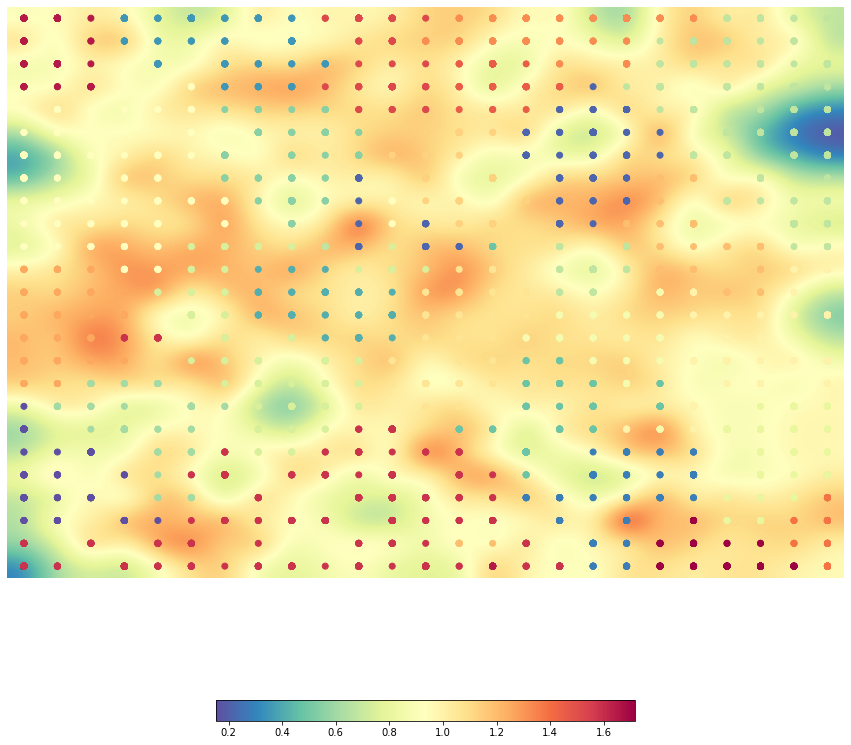

[[23 23 23  3  3  3  3  3  3 21 21 21 21 18 18 18 18 18 18 18 18  8  8  8
   8]
 [23 23 23  3  3  3  3  3  3  3 21 21 18 18 18 18 18 18 18  8  8  8  8  8
   8]
 [23 23 23  3  3  3  3  3  3  3 21 21 21 20 20 20 18 18 18  8  8  8  8  8
   8]
 [23 23 23 12 12 12  3  3  3 21 21 21 21 20 20 20 20  1  8  8  8  8  8  8
   8]
 [12 12 12 12 12 12  6  6  6  6 21 21 21 20 20 20  1  1  1  8  8  8  8  8
   8]
 [12 12 12 12 12 12  6  6  6  6  6 21 15 15 15  1  1  1  1  1  8  8  8  8
   8]
 [12 12 12 12 12 12  6  6  6  6  6 15 15 15 15  1  1  1  1  1  8  8  8  8
   8]
 [12 12 12 12 12 12  6  6  6  6  1 12 15 15 15 15  1  1  1 16 16  8  8  8
   8]
 [12 12 12 12 12 12 12  6  6  6  1 12 15 15 15 15  1  1  1 16 16  8  8  8
   8]
 [12 12 12 12 12 12 12 12  6  8  1 12  1 15 15 15  1  1 16 16 16 16  8  8
   8]
 [12 12 12 12 12  9  9  9  9  8  1  9  1  1  5  5  8  8  8 16 16 16 16  8
   8]
 [17 17 17 12 12  9  9  4  4  4  9  9  9 14 14 14  8  8  8 16 16 16 16 13
  13]
 [17 17 17 17  9  9  9  4  4  4  4  4 14

In [71]:
def cluster_report(som):
    som.view_umatrix(bestmatches=True, figsize=(15, 15), colorbar=True)
    print(som.clusters)
    
    cl_indices, counts = np.unique(som.clusters, return_counts=True)
    cl_cnt = np.vstack((cl_indices, counts))
    cl_cnt = cl_cnt[:, np.argsort(cl_cnt[1])]
    
    print("\nClusters sorted by increasing number of neurons:")
    print("Cluster index")
    print("Number of neurons")
    print(cl_cnt)
    
cluster_report(som)


## Σημασιολογική ερμηνεία των clusters

Προκειμένου να μελετήσουμε τις τοπολογικές ιδιότητες του SOM και το αν έχουν ενσωματώσει σημασιολογική πληροφορία για τις ταινίες διαμέσου της διανυσματικής αναπαράστασης με το tf-idf και των κατηγοριών, χρειαζόμαστε ένα κριτήριο ποιοτικής επισκόπησης των clusters. Θα υλοποιήσουμε το εξής κριτήριο: Λαμβάνουμε όρισμα έναν αριθμό (ετικέτα) cluster. Για το cluster αυτό βρίσκουμε όλους τους νευρώνες που του έχουν ανατεθεί από τον k-Means. Για όλους τους νευρώνες αυτούς βρίσκουμε όλες τις ταινίες που τους έχουν ανατεθεί (για τις οποίες αποτελούν bmus). Για όλες αυτές τις ταινίες τυπώνουμε ταξινομημένη τη συνολική στατιστική όλων των ειδών (κατηγοριών) και τις συχνότητές τους. Αν το cluster διαθέτει καλή συνοχή και εξειδίκευση, θα πρέπει κάποιες κατηγορίες να έχουν σαφώς μεγαλύτερη συχνότητα από τις υπόλοιπες. Θα μπορούμε τότε να αναθέσουμε αυτήν/ές την/τις κατηγορία/ες ως ετικέτες κινηματογραφικού είδους στο cluster.

Μπορείτε να υλοποιήσετε τη συνάρτηση αυτή όπως θέλετε. Μια πιθανή διαδικασία θα μπορούσε να είναι η ακόλουθη:

1. Ορίζουμε συνάρτηση `print_categories_stats` που δέχεται ως είσοδο λίστα με ids ταινιών. Δημιουργούμε μια κενή λίστα συνολικών κατηγοριών. Στη συνέχεια, για κάθε ταινία επεξεργαζόμαστε το string `categories` ως εξής: δημιουργούμε μια λίστα διαχωρίζοντας το string κατάλληλα με την `split` και αφαιρούμε τα whitespaces μεταξύ ετικετών με την `strip`. Προσθέτουμε τη λίστα αυτή στη συνολική λίστα κατηγοριών με την `extend`. Τέλος χρησιμοποιούμε πάλι την `np.unique` για να μετρήσουμε συχνότητα μοναδικών ετικετών κατηγοριών και ταξινομούμε με την `np.argsort`. Τυπώνουμε τις κατηγορίες και τις συχνότητες εμφάνισης ταξινομημένα. Χρήσιμες μπορεί να σας φανούν και οι `np.ravel`, `np.nditer`, `np.array2string` και `zip`.

2. Ορίζουμε τη βασική μας συνάρτηση `print_cluster_neurons_movies_report` που δέχεται ως όρισμα τον αριθμό ενός cluster. Με τη χρήση της `np.where` μπορούμε να βρούμε τις συντεταγμένες των bmus που αντιστοιχούν στο cluster και με την `column_stack` να φτιάξουμε έναν πίνακα bmus για το cluster. Προσοχή στη σειρά (στήλη - σειρά) στον πίνακα bmus. Για κάθε bmu αυτού του πίνακα ελέγχουμε αν υπάρχει στον πίνακα μοναδικών bmus που έχουμε υπολογίσει στην αρχή συνολικά και αν ναι προσθέτουμε το αντίστοιχο index του νευρώνα σε μια λίστα. Χρήσιμες μπορεί να είναι και οι `np.rollaxis`, `np.append`, `np.asscalar`. Επίσης πιθανώς να πρέπει να υλοποιήσετε ένα κριτήριο ομοιότητας μεταξύ ενός bmu και ενός μοναδικού bmu από τον αρχικό πίνακα bmus.

3. Υλοποιούμε μια βοηθητική συνάρτηση `neuron_movies_report`. Λαμβάνει ένα σύνολο νευρώνων από την `print_cluster_neurons_movies_report` και μέσω της `indices` φτιάχνει μια λίστα με το σύνολο ταινιών που ανήκουν σε αυτούς τους νευρώνες. Στο τέλος καλεί με αυτή τη λίστα την `print_categories_stats` που τυπώνει τις στατιστικές των κατηγοριών.

Μπορείτε βέβαια να προσθέσετε οποιαδήποτε επιπλέον έξοδο σας βοηθάει. Μια χρήσιμη έξοδος είναι πόσοι νευρώνες ανήκουν στο cluster και σε πόσους και ποιους από αυτούς έχουν ανατεθεί ταινίες.

Θα επιτελούμε τη σημασιολογική ερμηνεία του χάρτη καλώντας την `print_cluster_neurons_movies_report` με τον αριθμός ενός cluster που μας ενδιαφέρει. 

Παράδειγμα εξόδου για ένα cluster (μη βελτιστοποιημένος χάρτης, ωστόσο βλέπετε ότι οι μεγάλες κατηγορίες έχουν σημασιολογική  συνάφεια):

```
Overall Cluster Genres stats:  
[('"Horror"', 86), ('"Science Fiction"', 24), ('"B-movie"', 16), ('"Monster movie"', 10), ('"Creature Film"', 10), ('"Indie"', 9), ('"Zombie Film"', 9), ('"Slasher"', 8), ('"World cinema"', 8), ('"Sci-Fi Horror"', 7), ('"Natural horror films"', 6), ('"Supernatural"', 6), ('"Thriller"', 6), ('"Cult"', 5), ('"Black-and-white"', 5), ('"Japanese Movies"', 4), ('"Short Film"', 3), ('"Drama"', 3), ('"Psychological thriller"', 3), ('"Crime Fiction"', 3), ('"Monster"', 3), ('"Comedy"', 2), ('"Western"', 2), ('"Horror Comedy"', 2), ('"Archaeology"', 2), ('"Alien Film"', 2), ('"Teen"', 2), ('"Mystery"', 2), ('"Adventure"', 2), ('"Comedy film"', 2), ('"Combat Films"', 1), ('"Chinese Movies"', 1), ('"Action/Adventure"', 1), ('"Gothic Film"', 1), ('"Costume drama"', 1), ('"Disaster"', 1), ('"Docudrama"', 1), ('"Film adaptation"', 1), ('"Film noir"', 1), ('"Parody"', 1), ('"Period piece"', 1), ('"Action"', 1)]```
   

In [72]:
def print_categories_stats (movie_ids) :
  cats_in_total = list ()
  for id in movie_ids :
    cats_in_total.extend([cat.strip() for cat in (np.asscalar(categories[id])).split(",")])

  unique_cats, freqs = np.unique(cats_in_total, return_counts = True)
  sorted_args = np.argsort(-freqs)
  return (list (zip(list (unique_cats[sorted_args]), list (freqs[sorted_args]))))

In [73]:
def print_cluster_neurons_movies_report(cluster_index) :
  neurons_inds = list ()
  xs, ys = np.where(som.clusters == cluster_index)
  for bmu in list (zip(ys, xs)) :
    rows, cols = np.where(unique_bmus == bmu[0])
    for i in range(len(rows)) :
      if cols[i] == 1 :
        continue
      if unique_bmus[rows[i]][1] == bmu[1] :
        neurons_inds.append(rows[i])
        break
  return neurons_inds

In [74]:
def neurons_movies_report(neurons) :
  movie_ids = list ()
  for neuron_ind in neurons :
    movie_ids.append(indices[neuron_ind])
  return print_categories_stats(movie_ids)

In [60]:
"""
import collections

def print_categories_stats(ids, max_genres=-1):
    total_categories = []
    print("Total Movies: ", len(ids))

    for iid in ids:
        cat = categories[iid][0]
        total_categories.extend([cat_i.strip()[1:-1] for cat_i in cat.split(",")])

    if max_genres:
        return [cat for cat in collections.Counter(total_categories).most_common()[:max_genres]]
    
    return collections.Counter(total_categories).most_common()[:max_genres]

def print_cluster_neurons_movies_report(cluster, max_genres=-1):
    neurons = []
    rows, columns = np.where(cluster == som.clusters)
    cluster_bmus = np.column_stack((columns, rows))
    
    return print_categories_stats(neuron_movies_report(cluster_bmus), max_genres)
    
def neuron_movies_report(cluster_bmus):
    ids = []
    bmus_str = np.array([np.array2string(bmun) for bmun in bmus])
    for cbmu in cluster_bmus:
        indices = np.where(bmus_str == np.array2string(cbmu))[0]
        
        for i in indices:
            ids.append(i)
        
    return(ids)
"""

'\nimport collections\n\ndef print_categories_stats(ids, max_genres=-1):\n    total_categories = []\n    print("Total Movies: ", len(ids))\n\n    for iid in ids:\n        cat = categories[iid][0]\n        total_categories.extend([cat_i.strip()[1:-1] for cat_i in cat.split(",")])\n\n    if max_genres:\n        return [cat for cat in collections.Counter(total_categories).most_common()[:max_genres]]\n    \n    return collections.Counter(total_categories).most_common()[:max_genres]\n\ndef print_cluster_neurons_movies_report(cluster, max_genres=-1):\n    neurons = []\n    rows, columns = np.where(cluster == som.clusters)\n    cluster_bmus = np.column_stack((columns, rows))\n    \n    return print_categories_stats(neuron_movies_report(cluster_bmus), max_genres)\n    \ndef neuron_movies_report(cluster_bmus):\n    ids = []\n    bmus_str = np.array([np.array2string(bmun) for bmun in bmus])\n    for cbmu in cluster_bmus:\n        indices = np.where(bmus_str == np.array2string(cbmu))[0]\n        


## Tips για το SOM και το clustering

- Για την ομαδοποίηση ένα U-matrix καλό είναι να εμφανίζει και μπλε-πράσινες περιοχές (clusters) και κόκκινες περιοχές (ορίων). Παρατηρήστε ποια σχέση υπάρχει μεταξύ αριθμού ταινιών στο final set, μεγέθους grid και ποιότητας U-matrix.
- Για το k του k-Means προσπαθήστε να προσεγγίζει σχετικά τα clusters του U-matrix (όπως είπαμε είναι διαφορετικοί μέθοδοι clustering). Μικρός αριθμός k δεν θα σέβεται τα όρια. Μεγάλος αριθμός θα δημιουργεί υπο-clusters εντός των clusters που φαίνονται στο U-matrix. Το τελευταίο δεν είναι απαραίτητα κακό, αλλά μεγαλώνει τον αριθμό clusters που πρέπει να αναλυθούν σημασιολογικά.
- Σε μικρούς χάρτες και με μικρά final sets δοκιμάστε διαφορετικές παραμέτρους για την εκπαίδευση του SOM. Σημειώστε τυχόν παραμέτρους που επηρεάζουν την ποιότητα του clustering για το dataset σας ώστε να τις εφαρμόσετε στους μεγάλους χάρτες.
- Κάποια τοπολογικά χαρακτηριστικά εμφανίζονται ήδη σε μικρούς χάρτες. Κάποια άλλα χρειάζονται μεγαλύτερους χάρτες. Δοκιμάστε μεγέθη 20x20, 25x25 ή και 30x30 και αντίστοιχη προσαρμογή των k. Όσο μεγαλώνουν οι χάρτες, μεγαλώνει η ανάλυση του χάρτη αλλά μεγαλώνει και ο αριθμός clusters που πρέπει να αναλυθούν.




## Ανάλυση τοπολογικών ιδιοτήτων χάρτη SOM

Μετά το πέρας της εκπαίδευσης και του clustering θα έχετε ένα χάρτη με τοπολογικές ιδιότητες ως προς τα είδη των ταίνιών της συλλογής σας, κάτι αντίστοιχο με την εικόνα στην αρχή της Εφαρμογής 2 αυτού του notebook (η συγκεκριμένη εικόνα είναι μόνο για εικονογράφιση, δεν έχει καμία σχέση με τη συλλογή δεδομένων και τις κατηγορίες μας).

Για τον τελικό χάρτη SOM που θα παράξετε για τη συλλογή σας, αναλύστε σε markdown με συγκεκριμένη αναφορά σε αριθμούς clusters και τη σημασιολογική ερμηνεία τους τις εξής τρεις τοπολογικές ιδιότητες του SOM: 

1. Δεδομένα που έχουν μεγαλύτερη πυκνότητα πιθανότητας στο χώρο εισόδου τείνουν να απεικονίζονται με περισσότερους νευρώνες στο χώρο μειωμένης διαστατικότητας. Δώστε παραδείγματα από συχνές και λιγότερο συχνές κατηγορίες ταινιών. Χρησιμοποιήστε τις στατιστικές των κατηγοριών στη συλλογή σας και τον αριθμό κόμβων που χαρακτηρίζουν.
2. Μακρινά πρότυπα εισόδου τείνουν να απεικονίζονται απομακρυσμένα στο χάρτη. Υπάρχουν χαρακτηριστικές κατηγορίες ταινιών που ήδη από μικρούς χάρτες τείνουν να τοποθετούνται σε διαφορετικά ή απομονωμένα σημεία του χάρτη.
3. Κοντινά πρότυπα εισόδου τείνουν να απεικονίζονται κοντά στο χάρτη. Σε μεγάλους χάρτες εντοπίστε είδη ταινιών και κοντινά τους υποείδη.

Προφανώς τοποθέτηση σε 2 διαστάσεις που να σέβεται μια απόλυτη τοπολογία δεν είναι εφικτή, αφενός γιατί δεν υπάρχει κάποια απόλυτη εξ ορισμού για τα κινηματογραφικά είδη ακόμα και σε πολλές διαστάσεις, αφετέρου γιατί πραγματοποιούμε μείωση διαστατικότητας.

Εντοπίστε μεγάλα clusters και μικρά clusters που δεν έχουν σαφή χαρακτηριστικά. Εντοπίστε clusters συγκεκριμένων ειδών που μοιάζουν να μην έχουν τοπολογική συνάφεια με γύρω περιοχές. Προτείνετε πιθανές ερμηνείες.



Τέλος, εντοπίστε clusters που έχουν κατά την άποψή σας ιδιαίτερο ενδιαφέρον στη συλλογή της ομάδας σας (data exploration / discovery value) και σχολιάστε.


In [75]:
# Ανάλυση τοπολογικών ιδιοτήτων χάρτη SOM

cluster_col = list ()
neurons_col = list ()
category_col = list ()

for cluster_ind in range(best_k) :
  neurons = print_cluster_neurons_movies_report(cluster_ind)
  if neurons :
    cluster_col.append(cluster_ind)
    neurons_col.append(len(neurons))
    category_col.append(neurons_movies_report(neurons)[0][0])

stat_data = {'Cluster Index' : cluster_col, 'Most Frequent Category' : category_col, 'Cluster\'s Number of Neurons' : neurons_col}
stat_df = pd.DataFrame(data = stat_data)
print(stat_df.to_string(index = False))

 Cluster Index Most Frequent Category  Cluster's Number of Neurons
             0           "Short Film"                           15
             1         "World cinema"                           29
             2               "Action"                           20
             3               "Comedy"                           19
             4               "Horror"                           16
             5             "Thriller"                           17
             6               "Comedy"                           20
             7            "Animation"                           17
             8                "Drama"                           52
             9               "Horror"                           36
            10               "Action"                           18
            11             "Thriller"                           15
            12               "Comedy"                           45
            13        "Crime Fiction"                         

In [62]:
statistics = print_categories_stats([i for i in range(5000)])

print("10 most frequent categories of all movies : \n")
for i in range(10) :
  print(statistics[i])

print("\n10 less frequent categories of all movies : \n")
for i in range(0,10) :
  print(statistics[20 + i])

10 most frequent categories of all movies : 

('"Drama"', 2251)
('"Comedy"', 1254)
('"Thriller"', 805)
('"Romance Film"', 734)
('"Action"', 688)
('"World cinema"', 579)
('"Crime Fiction"', 516)
('"Horror"', 494)
('"Black-and-white"', 451)
('"Family Film"', 430)

10 less frequent categories of all movies : 

('"Fantasy"', 224)
('"Comedy film"', 216)
('"Crime Thriller"', 201)
('"War film"', 187)
('"Japanese Movies"', 156)
('"Psychological thriller"', 151)
('"Film adaptation"', 148)
('"Period piece"', 147)
('"Silent film"', 146)
('"Comedy-drama"', 145)


In [80]:
#Για να απομονώνουμε νευρώνες διαφόρων clusters της επιλογής μας
#και να παρατηρούμε την μεταξύ τους τοπολογία π.χ. για να 
#δούμε εάν όντως δύο ασυσχέτιστες κατηγορίες βρίσκονται 
#σε μεγάλη απόσταση μεταξύ τους και αντίστοιχα εάν δύο
#σχετικές κατηγορίες βρίσκονται κοντά

import matplotlib.pyplot as plt

def draw_clusters2(clusters, colors) :
  
  plt.figure(figsize=(8,8))
  axes = plt.gca()
  axes.set_facecolor('khaki')
  axes.set_xlim([-1,25])
  axes.set_ylim([25,-1])

  for i in range(len(clusters)) :
    x, y = np.where(som.clusters == clusters[i])
    cluster_points = list (zip (x, y))
    plt.plot(y, x, 'ro', color = colors[i], label = stat_df['Most Frequent Category'][clusters[i]])

  plt.title("Categories in SOM", color = 'black')
  plt.legend()
  plt.show()

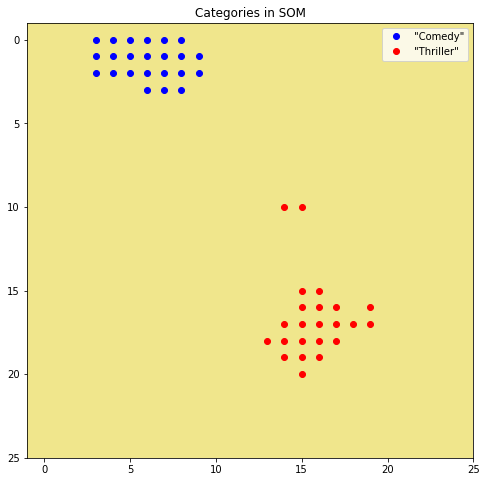

In [81]:
draw_clusters2([3,5], ['b', 'r'])

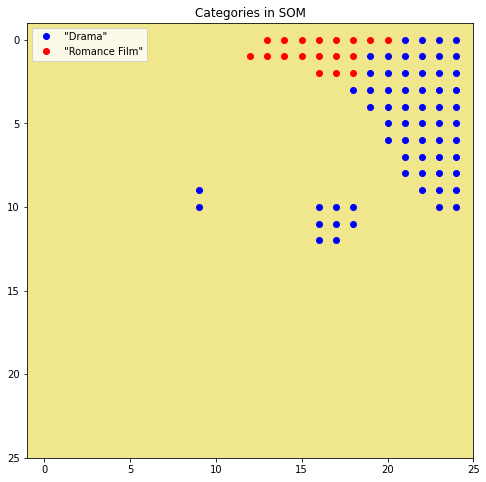

In [82]:
draw_clusters2([8,18], ['b', 'r'])

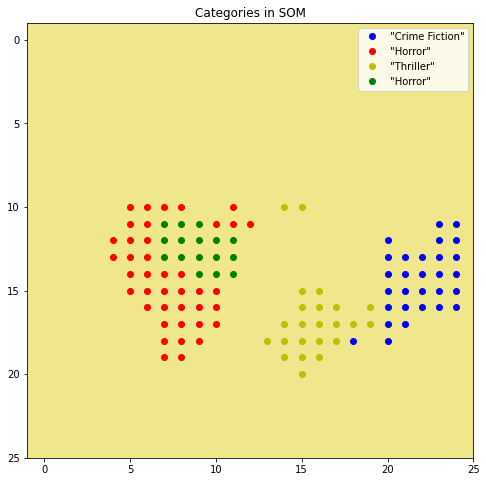

In [85]:
draw_clusters2([13,9,5, 4], ['b', 'r', 'y','g'])


1. Από τα παραπάνω κελία κώδικα βλέπουμε ότι οι κατηγορίες που έχουν την μεγαλύτερη πυκνότητα συγκέντρωσης είναι οι κατηγορίες Drama και Comedy.Για τον λόγο αυτόν βλέπουμε ότι τα 6 από τα 25 cluster έχουν τέτοιες ταινίες σε πλειοψηφία και ότι οι νευρώνες που αντιστοιχούν σε αυτά είναι περισσότερο.Επομένως,όντως η κατηγορία αυτή που έχει και την μεγαλύτερη πυκνότητα πιθανότητας στο χώρο εισόδου απεικονίζεται με τους περισσότερους νευρώνες και στον χώρο μειωμένης διάστασης. Αντιθέτως κατηγορίες με μικρή πυκνότητα πιθανότητα στον χώρο λαμβάνουν λιγότερους νευρώνες.

2. Στο 1ο γράφημα εμφανίζουμε τους cluster 8,18 με πολυπληθέστερες κατηγορίες Drama, Romance Film στον χάρτη και βλέπουμε ότι εμφανίζονται σε κοντινή απόσταση στο πάνω δεξία μέρος του χάρτη. 

3. Στο 2ο γράφημα εμφανίζουμε τους cluster 3,5 με πολυπληθέστερες κατηγορίες Comedy, Thriller στον χάρτη δηλαδή δύο κατηγορίες που νοηματικά δεν συνδυάζονται και βλέπουμε ότι εμφανίζονται σε μακρινή απόσταση.
 


# Τελική παράδοση άσκησης

- Θα παραδώσετε στο eclass το παρόν notebook επεξεργασμένο ή ένα νέο με τις απαντήσεις σας για τα ζητούμενα και των δύο εφαρμογών. 
- Θυμηθείτε ότι η ανάλυση του χάρτη στο markdown με αναφορά σε αριθμούς clusters πρέπει να αναφέρεται στον τελικό χάρτη με τα κελιά ορατά που θα παραδώσετε αλλιώς ο χάρτης που θα προκύψει θα είναι διαφορετικός και τα labels των clusters δεν θα αντιστοιχούν στην ανάλυσή σας. 
- Μην ξεχάσετε στην αρχή ένα κελί markdown με **τα στοιχεία της ομάδας σας**.
- Στο **zip** που θα παραδώσετε πρέπει να βρίσκονται **2 αρχεία (το .ipynb και το .py του notebook σας)**.

<table>
  <tr><td align="center">
    <font size="4">Παρακαλούμε διατρέξτε βήμα-βήμα το notebook για να μην ξεχάσετε παραδοτέα!</font>
</td>
  </tr>
</table>